# SandBox for Chest Xray Dataset Images

## Data Source


### Publication

https://arxiv.org/abs/1705.02315

### URL

https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/37178474737

In [142]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
from matplotlib import pyplot as plt
from matplotlib import cm
from warnings import warn
import os
import re

In [2]:
top_dir = '/home/owhitley/projects/chest_xray_8'
data_dir = os.path.join(top_dir, 'data')
image_dir = os.path.join(data_dir, 'images')
output_dir = os.path.join(top_dir, 'results')
if not os.path.exists(output_dir):
    os.mkdir(output_dir)


In [3]:
os.listdir(data_dir)

['ChestXray_NIHCC_Download.py',
 'ChestXray_NIHCC_Download_out.txt',
 'images',
 'ChestXray_NIHCC_Download_err.txt',
 'Data_Entry_2017_v2020.csv',
 'README.txt']

# Examine a few images

Modified code from [here](https://matplotlib.org/3.3.3/gallery/images_contours_and_fields/multi_image.html#sphx-glr-gallery-images-contours-and-fields-multi-image-py)

In [4]:
# number of images downloaded
len(os.listdir(image_dir))

24999

In [5]:
# example image files
ex_img_files = os.listdir(image_dir)[:5]
ex_img_files

['00006304_041.png',
 '00001498_000.png',
 '00004402_008.png',
 '00003028_069.png',
 '00001722_001.png']

In [6]:
len(ex_img_files)

5

0
1
2
3
4


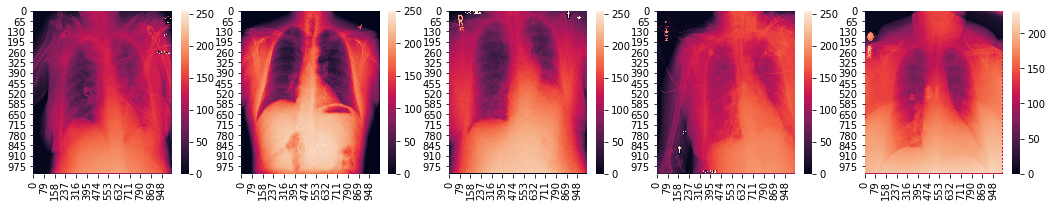

In [7]:

def implot(imgs, rows, columns, fig_width, fig_height):

    fig, axs =plt.subplots(rows, columns, figsize=(fig_width, fig_height))
    m = 0
    
    for i in range(rows):
        for j in range(columns):
            print(m)
            ex_img = imgs[m]
            if rows == 1:
                sns.heatmap(ex_img, ax = axs[j])
            elif cols == 1:
                sns.heatmap(ex_img, ax = axs[i])
            else:
                sns.heatmap(ex_img, ax = axs[i, j])
            m += 1

    plt.show()
img_list = [io.imread(os.path.join(image_dir, ex_img_files[m])) for m in range(len(ex_img_files))]    
implot(img_list, 1, 5, 18, 3)


In [8]:
# all images appear to be 1024/1024
for i in range(len(img_list)):
    print(img_list[i].shape)

(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)


/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

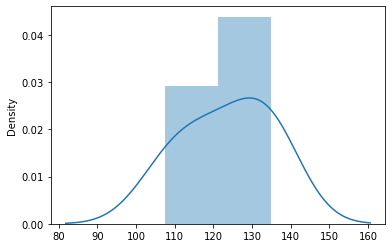

In [9]:

img_means = []
for i in range(len(img_list)):
    img_means.append(np.mean(img_list[i]))

sns.distplot(img_means)

In [10]:
# mean intensity
mean_intensity = np.mean(np.array(img_list))
mean_intensity

123.49591274261475

In [11]:
# std deviation
std_intensity = np.std(np.array(img_list))
std_intensity

58.199618203287606

# Define Classes/Methods for Preprocessing and Indexing Data

In [14]:
# Classes with callable methods to be used for transforms
class SampleTransform(object):
    """
    Generic Class for doing a transform of image data in a sample dict. Note that this could be extended
    to include transformations on tabular data as well, but for now we're only worried about image data
    """
    def __init__(self, img_transform):
        # img_transform must be subclass of nn.Module
        self.img_transform = img_transform
        
    def __transform__(self, sample):
        raise NotImplementedError('method __transform__ not defined for this class.')
    
    def __call__(self, sample):
        image, table_data = sample['image'], sample['table_data']
        transf_image = self.__transform__(image)
        sample_return = {'image': transf_image, 'table_data': table_data}
        return sample_return
        
class ToTensor(SampleTransform):
    """
    Turns image into a pytorch tensor. See docs for
    torchvision.transforms.ToTensor() for more details
    """
    def __init__(self):
        super().__init__(img_transform = transforms.ToTensor())
        
    def __transform__(self, image):
        transf_image = self.img_transform.__call__(image)
        return transf_image
    
class Normalize(SampleTransform):
    """
    Normalize an image to specified mean and std deviation
    """
    def __init__(self, mean, std, inplace = False):
        super().__init__(img_transform = transforms.Normalize(mean, std, inplace))
        
    def __transform__(self, image):
        transf_image = self.img_transform.__call__(image)
        return transf_image

class RandomHorizontalFlip(SampleTransform):
    """
    Performs random horizontal flip of image with p = 0.5 for the flip
    See docs for torchvision.transforms.RandomHorizontalFlip for more details
    """
    def __init__(self):
        super().__init__(img_transform = transforms.RandomHorizontalFlip())
        
    def __transform__(self, image):
        transf_image = self.img_transform.__call__(image)
        return transf_image

In [15]:
basic_transform = transforms.Compose([
        ToTensor(),
        Normalize(mean_intensity, std_intensity),
        RandomHorizontalFlip()
    ])

In [105]:
class XRayDataset(Dataset):
    """
    Xray images dataset. Inspired in part by: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    Used to manage indexing of tabular and image data, as well as do limited transformations of tabular data
    """
    
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with tabular data corresponding to images.
            root_dir (string): Directory with all the images. Assumes all images in 1 directory, (no subdirectories)
            transform (callable, optional): Optional transform to be applied
                on a sample.
        Notes:
            csv file is read, and then listed images checked against those actually present in root_dir
            only images in the intersection of images listed in csv file and images present in root_dir
            will be used in the XRayDataSet object. Also, transforms could range from initial preprocessing
            for images to be used in training autoencoder to running images through preprocessing and 
            
        TODO: 
                * add other methods for transforming tabular data or retrieving transformed tabular data,
                notably one hot encoding of classes or multiclasses if we ever want to get to that.
        """
        self.table_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
        # subset tabular data only for images in intersection of tabular data and images present in root_dir
        tab_images = self.table_data['Image Index'].to_numpy().astype('str')
        dir_images = os.listdir(root_dir)
        common_images = np.intersect1d(tab_images, dir_images)
        msg = "{0} images common to root_dir ({1} images) and csv_file ({2} images)"
        print(msg.format(len(common_images), len(dir_images), len(tab_images)))
        
        if len(common_images) < 1:
            raise ValueError('0 images common between root_dir and csv_file')
        
        idx_keep = np.in1d(tab_images, common_images)
        self.table_data = self.table_data.iloc[idx_keep, :]
        
        self.transform = transform
        
    def __len__(self):
        return(len(self.table_data))
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.table_data.iloc[idx, 0])
        image = io.imread(img_name)
        # gets 1 row of dataframe if idx of len 1 and returns it as pandas dataframe.
        # not sure why this doesn't happen if you just pass the row index
        table_data = self.table_data.iloc[np.arange(idx, idx + 1), 1:]
        
        sample = {'image': image, 'table_data': table_data}

        if self.transform:
            sample = self.transform(sample)

        return sample
        
    def get_label_names(self, col):
        """
        get unique label names. assume multilabel entries are separated
        by a pipe character
        """
        # get unique label names
        label_names = [re.split('\|', x) for x in FindingLabels.to_numpy().astype('str')]
        label_names = np.unique(np.array([x for y in label_names for x in y]))
        return label_names
        
    def one_hot(self, col, label):
        """
        One-hot encode a particular label in categorical data. 
        """
        r = re.compile('(\|)*' + label + '(\|)*')
        col_content = self.table_data[col].to_numpy().astype('str')
        vmatch = np.vectorize(lambda x:bool(r.search(x)))
        sel = vmatch(col_content).astype('int32')
        new_col = label
        if new_col in self.table_data.keys():
            warn(new_col + ' is already present in dataframe, replacing')
        self.table_data[new_col] = sel
        
    def one_hot_all_labels(self, col):
        """
        One hot encode all unique labels in a column. Assume that multilabel entries are
        separated by a pipe | character
        """
        all_labels = self.get_label_names(col)
        for label in all_labels:
            self.one_hot(col, label)
            
    def get_multi_label(self, col):
        """
        """
        r = re.compile('\|')
        col_content = self.table_data[col].to_numpy().astype('str')
        vmatch = np.vectorize(lambda x:bool(r.search(x)))
        sel = vmatch(col_content).astype('int32')
        new_col = col + '_IsMultiLabel'
        if new_col in self.table_data.keys():
            warn(new_col + ' is already present in dataframe, replacing')
        self.table_data[new_col] = sel
        
        

In [106]:
VAE_DS = XRayDataset(csv_file = os.path.join(data_dir, 'Data_Entry_2017_v2020.csv'), 
                     root_dir = image_dir, transform = basic_transform)

24999 images common to root_dir (24999 images) and csv_file (112120 images)


In [107]:
# check that data transform works
proc_img_list = [VAE_DS[i]['image'].numpy()[0, :, :] for i in range(5)]

0
1
2
3
4


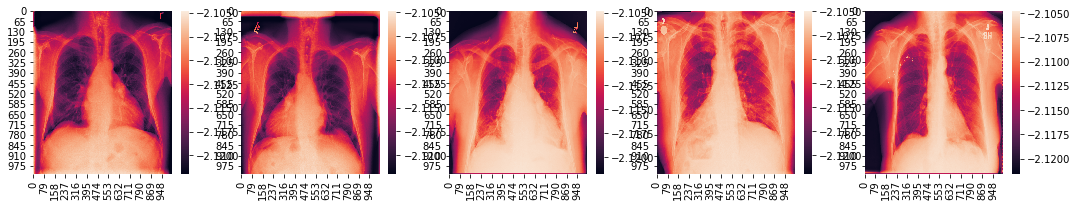

In [108]:
implot(proc_img_list, 1, 5, 18, 3)

/home/owhitley/anaconda3/envs/pytorch36/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

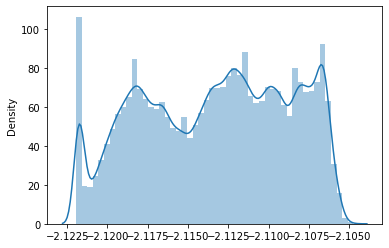

In [141]:
sns.distplot(np.array(proc_img_list[0]).flatten())

# Define Model

For now we start out with a relatively simple architecture for encoder + decoder. If we really want to get fancy can consider resnet or inception layers, but for now let's get a simple first pass done. Code in large part borrowed from https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb.

For the most part it appears that pixel intensity follows a distribution of a mixture of gaussians, so for now it might be best to use gaussian $log p(x|z) $ instead of bernoulli equivalent (i.e. binary cross entropy)

In [135]:
# calculate outputs of successive conv layers
(1080 + 2 - 4)/2 + 1

540.0

In [137]:
(540 + 2 - 4)/2 + 1

270.0

In [138]:
(270 + 2 - 4)/2 + 1

135.0

In [139]:
(135 + 2 - 4)/2 + 1

67.5

In [ ]:
class Encoder(nn.Module):
    def __init__(self, c):
        super(Encoder, self).__init__()
        # note: can make
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 540 x 540
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: 2c x 270 x 270
        self.conv3 = nn.Conv2d(in_channels=c, out_channels=c*4, kernel_size=4, stride=2, padding=1) # out: 4c x 135 x 135
        self.fc_mu = nn.Linear(in_features=c*4*135*135 out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*4*135*135, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar 

    
class Decoder(nn.Module):
    def __init__(self, c):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*4*135*135)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*4, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*4, 135, 135) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = F.linear(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            # std deviation = sqrt(var) or exp(1/2 logvar) 
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            # It appears that when not training, you want to return the 'expected' position
            return mu

def vae_loss(recon_x, x, mu, logvar):
    """
    recon_x = reconstructed images of x
    x = original set of images
    mu = mean
    logvar = log-variance
    """
    std_pixels = torch.std(x)
    
        


# Define Classes/Functions to Be Used for Training and Evaluation

# Exploration of Tabular Data

We explore the distribution of Finding Labels and other image related tabular data, such as patient age, patient ID, and patient gender

In [109]:
total_images = VAE_DS.__len__()
total_images

24999

In [110]:
VAE_DS.table_data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
24994,00006585_002.png,Mass,2,6585,15,F,AP,2500,2048,0.168,0.168
24995,00006585_003.png,No Finding,3,6585,15,F,AP,2048,2500,0.168,0.168
24996,00006585_004.png,No Finding,4,6585,15,F,AP,2500,2048,0.168,0.168
24997,00006585_005.png,No Finding,5,6585,15,F,PA,2048,2500,0.168,0.168


In [111]:
VAE_DS.one_hot_all_labels('Finding Labels')

In [112]:
VAE_DS.table_data.loc[:, VAE_DS.get_label_names('Finding Labels')]

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
24995,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
24996,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
24997,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [113]:
VAE_DS.get_multi_label('Finding Labels')

In [118]:
# check distribution of Finding Labels. 
label_names = np.concatenate((VAE_DS.get_label_names('Finding Labels'), np.array(['Finding Labels_IsMultiLabel'])))
for lab in label_names:
    print("{}: {}".format(lab, np.sum(VAE_DS.table_data[lab].to_numpy())))

Atelectasis: 2270
Cardiomegaly: 820
Consolidation: 916
Edema: 349
Effusion: 2332
Emphysema: 476
Fibrosis: 554
Hernia: 59
Infiltration: 3714
Mass: 846
No Finding: 14597
Nodule: 1221
Pleural_Thickening: 741
Pneumonia: 288
Pneumothorax: 951
Finding Labels_IsMultiLabel: 3762


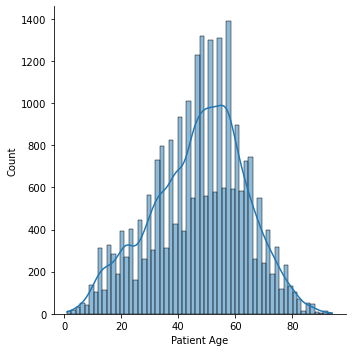

In [125]:
# Check Distribution of Ages
sns.displot(VAE_DS.table_data['Patient Age'], kde = True)

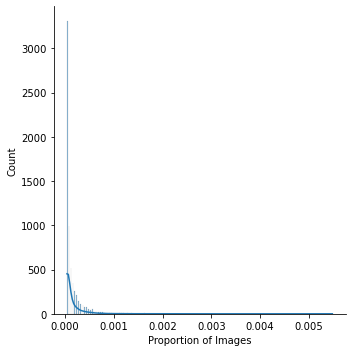

In [128]:
# check proportion of images accounted for by each patient.
# It turns out that a small proportion of patients each account for 5 in every 1000 images or so.
# Still, this isn't horrifyinglying biased towards any individual patient
g = sns.displot(VAE_DS.table_data['Patient ID'].value_counts()/np.float(total_images), kde = True)
g.set_axis_labels("Proportion of Images", "Count")

In [129]:
# Check Male/Female Distribution
VAE_DS.table_data['Patient Gender'].value_counts()

M    13362
F    11637
Name: Patient Gender, dtype: int64

<AxesSubplot:xlabel='Patient Gender', ylabel='Patient Age'>

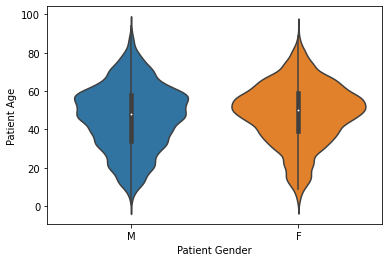

In [134]:
# Age follows somewhat similar distribution among both genders
sns.violinplot(data = VAE_DS.table_data, x = 'Patient Gender', y = 'Patient Age')